**Librerias necesarias para el análisis**

In [73]:
import numpy as np  # Cálculos numéricos con arreglos y matrices
import seaborn as sns  # Gráficos estadísticos
import plotly.express as px  # Gráficos interactivos
from flask import Flask, render_template, jsonify, request  # Crear app web con Flask
import matplotlib  # Librería base para gráficos
import matplotlib.pyplot as plt  # Crear gráficos estáticos
import pandas as pd  # Manipulación y análisis de datos tabulares
import os  # Manejo de rutas y archivos del sistema
from sklearn.model_selection import train_test_split  # Dividir datos en entrenamiento/prueba
from sklearn.tree import DecisionTreeRegressor  # Modelo predictivo tipo árbol para regresión
from sklearn.metrics import mean_squared_error, r2_score  # Métricas de evaluación del modelo

# Data base con los 6000 reportes

La base de datos recopila información operativa de una planta industrial con el fin de monitorear, analizar y predecir el rendimiento del proceso productivo.

# Objetivo:

Proveer datos históricos que permitan:

Evaluar la eficiencia del proceso.

Predecir el rendimiento (eficiencia porcentual).

Identificar factores que afectan la producción y calidad.


# Posible Origen:

Recolectada desde sensores industriales (IoT), registros operativos y sistemas SCADA/MES de control de planta.


# Variables Numéricas:

temperatura: grados Celsius en el proceso.

vibración: medida de inestabilidad mecánica.

humedad: porcentaje de humedad ambiental o interna.

tiempo_ciclo: duración promedio del ciclo de producción (segundos).

cantidad_producida: total de unidades fabricadas por sesión.

unidades_defectuosas: cantidad de productos con defectos.

eficiencia_porcentual: rendimiento general del proceso (%).

consumo_energia: energía consumida (kWh).

paradas_programadas: cantidad de pausas planeadas.

paradas_imprevistas: fallos o detenciones inesperadas.


# Variables Categóricas:

turno: jornada de trabajo (mañana, noche, etc.).

operador_id: identificador del operario responsable.

maquina_id: código único de la máquina utilizada.

producto_id: tipo o referencia del producto fabricado.

fallo_detectado: indicador binario (sí/no) de fallo en producción.

tipo_fallo: categoría del fallo ocurrido (eléctrico, mecánico, software, etc.).

# Se carga la data base

In [88]:
df = pd.read_csv('/content/Dataset_Talento.csv')

# Se ven las primeras filas (5)

In [89]:
df.head()

,timestamp,turno,operador_id,maquina_id,producto_id,temperatura,vibración,humedad,tiempo_ciclo,fallo_detectado,tipo_fallo,cantidad_producida,unidades_defectuosas,eficiencia_porcentual,consumo_energia,paradas_programadas,paradas_imprevistas,observaciones
0,2023-01-01 00:00:00,Noche,OP_16,M_8,P_14,74.200401,NaN,45.209387,106.356684,No,NaN,108,3,87.021704,13.131580,0,1,NaN
1,2023-01-01 01:00:00,Mañana,OP_18,M_8,P_12,85.886727,0.481294,52.623286,106.147220,Sí,Eléctrico,86,2,81.200758,13.348221,0,0,NaN
2,2023-01-01 02:00:00,Noche,OP_5,M_7,P_14,81.293588,0.446638,48.538203,122.517733,No,NaN,103,0,79.104477,15.461715,3,0,Operación normal
3,2023-01-01 03:00:00,Noche,OP_4,M_6,P_15,75.697975,0.576969,55.597781,123.641235,No,NaN,104,2,84.176537,16.156453,4,0,NaN
4,2023-01-01 04:00:00,Mañana,OP_13,M_6,P_7,69.887504,0.716240,63.837428,126.276992,No,NaN,119,1,93.535084,12.573939,0,0,Operación normal


# Se ven las últimas filas (5)

In [90]:
df.tail()

,timestamp,turno,operador_id,maquina_id,producto_id,temperatura,vibración,humedad,tiempo_ciclo,fallo_detectado,tipo_fallo,cantidad_producida,unidades_defectuosas,eficiencia_porcentual,consumo_energia,paradas_programadas,paradas_imprevistas,observaciones
5995,2023-09-07 19:00:00,Mañana,OP_7,M_9,P_2,69.566198,0.359394,31.452299,110.456904,No,NaN,85,6,83.359399,17.467713,1,0,NaN
5996,2023-09-07 20:00:00,Tarde,OP_16,M_9,P_1,72.509325,0.387216,45.429609,145.575235,No,NaN,109,4,87.847138,11.850616,0,0,NaN
5997,2023-09-07 21:00:00,Noche,OP_3,M_7,P_11,72.452851,0.551448,27.774960,74.620786,No,NaN,109,0,NaN,NaN,1,1,Revisar calibración
5998,2023-09-07 22:00:00,Tarde,OP_7,M_6,P_1,74.236404,0.429883,41.528769,111.656062,No,NaN,101,3,87.225639,17.073040,0,0,NaN
5999,2023-09-07 23:00:00,Tarde,OP_6,M_3,P_1,70.501856,0.612991,59.584130,119.290237,No,NaN,82,2,75.578950,13.310307,2,0,Operación normal


# Descripción del tamaño de la db

In [91]:
df.shape

(6000, 18)

# Nombres de la columnas (variables)

In [92]:
df.columns

Index(['timestamp', 'turno', 'operador_id', 'maquina_id', 'producto_id',
       'temperatura', 'vibración', 'humedad', 'tiempo_ciclo',
       'fallo_detectado', 'tipo_fallo', 'cantidad_producida',
       'unidades_defectuosas', 'eficiencia_porcentual', 'consumo_energia',
       'paradas_programadas', 'paradas_imprevistas', 'observaciones'],
      dtype='object')

# Información general de tipos de datos y nulos

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              6000 non-null   object 
 1   turno                  6000 non-null   object 
 2   operador_id            6000 non-null   object 
 3   maquina_id             6000 non-null   object 
 4   producto_id            6000 non-null   object 
 5   temperatura            5820 non-null   float64
 6   vibración              5820 non-null   float64
 7   humedad                5820 non-null   float64
 8   tiempo_ciclo           5820 non-null   float64
 9   fallo_detectado        6000 non-null   object 
 10  tipo_fallo             599 non-null    object 
 11  cantidad_producida     6000 non-null   int64  
 12  unidades_defectuosas   6000 non-null   int64  
 13  eficiencia_porcentual  5820 non-null   float64
 14  consumo_energia        5820 non-null   float64
 15  para

## Estadísticas descriptivas para columnas numéricas

In [94]:
df.describe()

,temperatura,vibración,humedad,tiempo_ciclo,cantidad_producida,unidades_defectuosas,eficiencia_porcentual,consumo_energia,paradas_programadas,paradas_imprevistas
count,5820.000000,5820.000000,5820.000000,5820.000000,6000.000000,6000.000000,5820.000000,5820.000000,6000.000000,6000.000000
mean,74.980189,0.502242,44.964716,119.912532,99.978833,2.001167,84.972214,15.104971,0.996500,0.497667
std,4.944594,0.099881,9.970650,19.907796,10.086592,1.403743,5.070294,2.995096,1.002824,0.695755
min,57.900924,0.052148,0.345502,53.707495,65.000000,0.000000,66.650206,3.693371,0.000000,0.000000
25%,71.622436,0.434502,38.284044,106.615342,93.000000,1.000000,81.541885,13.084013,0.000000,0.000000
50%,74.943301,0.503101,44.723372,120.060829,100.000000,2.000000,85.053793,15.052808,1.000000,0.000000
75%,78.294546,0.572244,51.632339,133.023427,107.000000,3.000000,88.440798,17.136321,2.000000,1.000000
max,95.739475,0.832678,81.402316,201.989007,137.000000,10.000000,102.024829,26.699891,6.000000,5.000000


#Revisar valores faltantes en todas las variables

In [95]:
df.isnull().sum()

,0
timestamp,0
turno,0
operador_id,0
maquina_id,0
producto_id,0
temperatura,180
vibración,180
humedad,180
tiempo_ciclo,180
fallo_detectado,0


#Como los datos faltantes en temperatura, vibración, humedad, tiempo_ciclo, eficiencia_porcentual y consumo_energia son pocos en comparación al total de los datos, se reemplazarán esos espacios faltantes por la media de cada variable

In [96]:
df['temperatura'] = df['temperatura'].fillna(df['temperatura'].mean())
df['vibración'] = df['vibración'].fillna(df['vibración'].mean())
df['humedad'] = df['humedad'].fillna(df['humedad'].mean())
df['tiempo_ciclo'] = df['tiempo_ciclo'].fillna(df['tiempo_ciclo'].mean())
df['eficiencia_porcentual'] = df['eficiencia_porcentual'].fillna(df['eficiencia_porcentual'].mean())
df['consumo_energia'] = df['consumo_energia'].fillna(df['consumo_energia'].mean())

#Revisar valores faltantes en todas las variables

In [97]:
df.isnull().sum()

,0
timestamp,0
turno,0
operador_id,0
maquina_id,0
producto_id,0
temperatura,0
vibración,0
humedad,0
tiempo_ciclo,0
fallo_detectado,0


#Para los datos tipo_fallo se llenarán los datos faltantes por No reportado

In [98]:
df['tipo_fallo'] = df['tipo_fallo'].fillna('No reportado')

#Para los datos observaciones se llenarán los datos faltantes por Sin observaciones

In [99]:
df['observaciones'] = df['observaciones'].fillna('Sin observaciones')

#Revisar valores faltantes en todas las variables

In [100]:
df.isnull().sum()

,0
timestamp,0
turno,0
operador_id,0
maquina_id,0
producto_id,0
temperatura,0
vibración,0
humedad,0
tiempo_ciclo,0
fallo_detectado,0


# Exportar dataset

In [101]:
output_path = '/content/Dataset_Talento_listo.xlsx'
df.to_excel(output_path, index=False)

# Así tendriamos todas las variables sin ningún valor faltante

In [102]:
# Crear columna con índice de defectos
df['indice_defectos'] = (df['unidades_defectuosas'] / df['cantidad_producida']) * 100

# Calcular promedio del índice de defectos por máquina
defectos_por_maquina = df.groupby('maquina_id')['indice_defectos'].mean().sort_values(ascending=False)
print(defectos_por_maquina)

maquina_id
M_3     2.103150
M_7     2.099078
M_2     2.054113
M_9     2.053698
M_4     2.030225
M_1     2.020330
M_5     2.019878
M_6     1.991376
M_10    1.972957
M_8     1.883147
Name: indice_defectos, dtype: float64


# Modelo Predictivo con Regresión Lineal



Este análisis utiliza un modelo de regresión lineal para predecir la cantidad de unidades defectuosas a partir de la temperatura en el proceso productivo.


**Objetivo:**
Estimar cuántos defectos podrían generarse bajo ciertas condiciones de temperatura.


Detectar patrones y apoyar decisiones preventivas.


**Proceso:**

Se define la temperatura como variable de entrada y las unidades defectuosas como variable objetivo.


Se entrena un modelo de regresión lineal con datos históricos.

Se realizan predicciones con nuevos valores de temperatura.


Se evalúa el modelo usando error cuadrático medio (MSE).


Se visualiza la comparación entre valores reales y predichos.


**Resultados:**
El modelo permite anticipar el número de defectos.


Si los datos no siguen una relación lineal, puede ser necesario un modelo más complejo (como árbol de decisión).

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



Cantidad de unidades Defectuosas: 2.111450118900723
Error cuadrático medio: 1.967269952918611


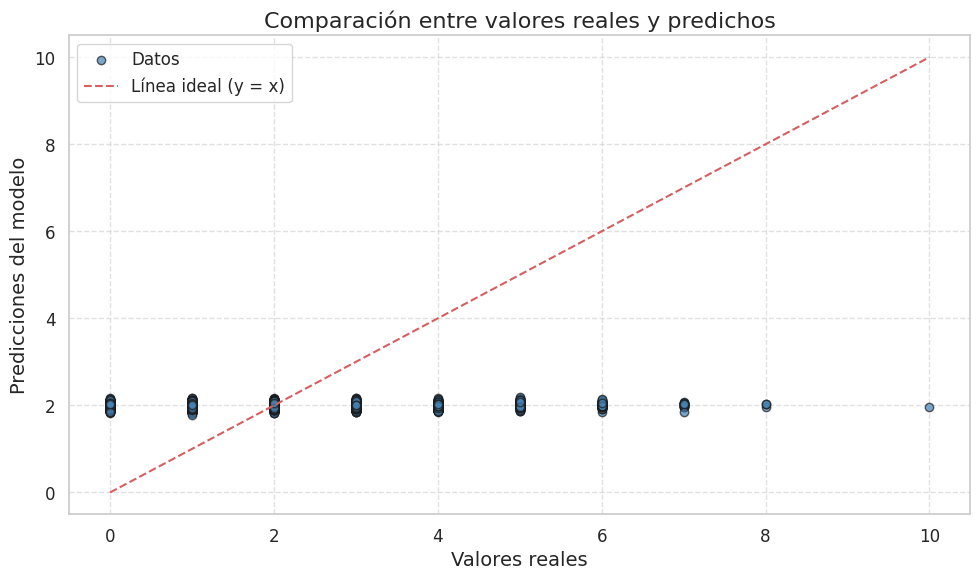

In [103]:
# ----------------------------------------------
# Definimos las variables de entrada (X) y la variable de salida (y)
# X son las características que se usarán para hacer la predicción
X = df[['temperatura']]
# y es la variable objetivo que queremos predecir: cuántas unidades defectuosas hubo
y = df['unidades_defectuosas']

# ----------------------------------------------
# Entrenamos un modelo de regresión lineal
from sklearn.linear_model import LinearRegression

modelo = LinearRegression()  # Creamos un modelo de regresión lineal
modelo.fit(X, y)             # Entrenamos el modelo con los datos del DataFrame

# ----------------------------------------------
# Realizamos una predicción con nuevos datos
nueva_data = [[65]]  # Estos son nuevos valores de entrada (temperatura, humedad, etc.)
prediccion = modelo.predict(nueva_data)  # El modelo hace la predicción con esos valores
print("Cantidad de unidades Defectuosas:", prediccion[0])  # Mostramos el resultado en pantalla

# ----------------------------------------------
# Evaluamos el modelo usando el error cuadrático medio (MSE)
from sklearn.metrics import mean_squared_error

predicciones = modelo.predict(X)  # Hacemos predicciones con todos los datos de entrenamiento
error = mean_squared_error(y, predicciones)  # Calculamos el error entre los valores reales y los predichos
print("Error cuadrático medio:", error)  # Imprimimos el valor del error

# ----------------------------------------------
# Visualizamos gráficamente cómo se comparan los valores reales con los predichos

# Creamos una figura más grande para que se vea mejor
plt.figure(figsize=(10, 6))

# Dibujamos un gráfico de dispersión (scatter plot) con los valores reales (y) y las predicciones
plt.scatter(y, predicciones, color='steelblue', alpha=0.7, edgecolor='k', label='Datos')  # alpha es la transparencia

# Dibujamos una línea punteada roja que representa la "predicción ideal"
# Es decir, donde los valores reales y los predichos serían exactamente iguales (y = x)
min_val = min(min(y), min(predicciones))  # El valor mínimo entre reales y predichos
max_val = max(max(y), max(predicciones))  # El valor máximo entre reales y predichos
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Línea ideal (y = x)')  # Línea roja punteada

# Añadimos etiquetas a los ejes y un título al gráfico
plt.xlabel('Valores reales', fontsize=14)
plt.ylabel('Predicciones del modelo', fontsize=14)
plt.title('Comparación entre valores reales y predichos', fontsize=16)

# Añadimos una cuadrícula y una leyenda para mejor comprensión
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustamos el diseño del gráfico para que no se corte nada
plt.tight_layout()

# Mostramos el gráfico en pantalla
plt.show()

# Análisis exploratorio (EDA):

# Graficar eficiencia vs. temperatura, eficiencia vs. vibración, etc.
#Ver si eficiencia depende del turno, operador o máquina


El análisis exploratorio de datos (EDA) busca identificar patrones y relaciones entre las variables que afectan el rendimiento operativo de la empresa. En este estudio, se examina cómo factores numéricos como temperatura, vibración, humedad y tiempo de ciclo influyen en la eficiencia porcentual, y cómo variables categóricas como el turno, operador o máquina pueden impactar en la producción y calidad. Las visualizaciones permiten detectar comportamientos atípicos, comparar promedios y establecer hipótesis útiles para la construcción del modelo predictivo.

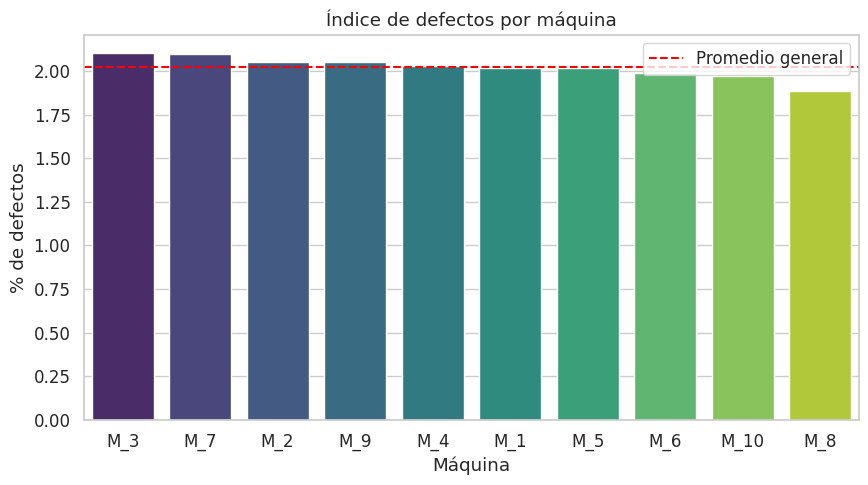

In [104]:


df['indice_defectos'] = (df['unidades_defectuosas'] / df['cantidad_producida']) * 100  # Crea una nueva columna con el porcentaje de defectos
promedio_defectos = df['indice_defectos'].mean()  # Calcula el promedio del índice de defectos

plt.figure(figsize=(10,5))  # Define el tamaño de la figura del gráfico
sns.barplot(x=defectos_por_maquina.index, y=defectos_por_maquina.values, hue=defectos_por_maquina.index, palette='viridis', legend=False)  # Crea un gráfico de barras por máquina con colores diferenciados
plt.axhline(promedio_defectos, color='red', linestyle='--', label='Promedio general')  # Dibuja una línea horizontal en el promedio de defectos
plt.title('Índice de defectos por máquina')  # Establece el título del gráfico
plt.ylabel('% de defectos')  # Etiqueta del eje Y
plt.xlabel('Máquina')  # Etiqueta del eje X
plt.legend()  # Muestra la leyenda del gráfico
plt.show()  # Renderiza y muestra el gráfico

plt.show()

# Análisis visual exploratorio

Este bloque de código genera un análisis visual exploratorio que permite observar la relación entre la eficiencia porcentual y distintas variables numéricas del proceso productivo (como temperatura, vibración, humedad, entre otras). Para cada variable, se construye un diagrama de dispersión con una línea de tendencia que facilita identificar posibles correlaciones. El objetivo es detectar qué factores podrían estar influyendo positiva o negativamente en la eficiencia de la producción.

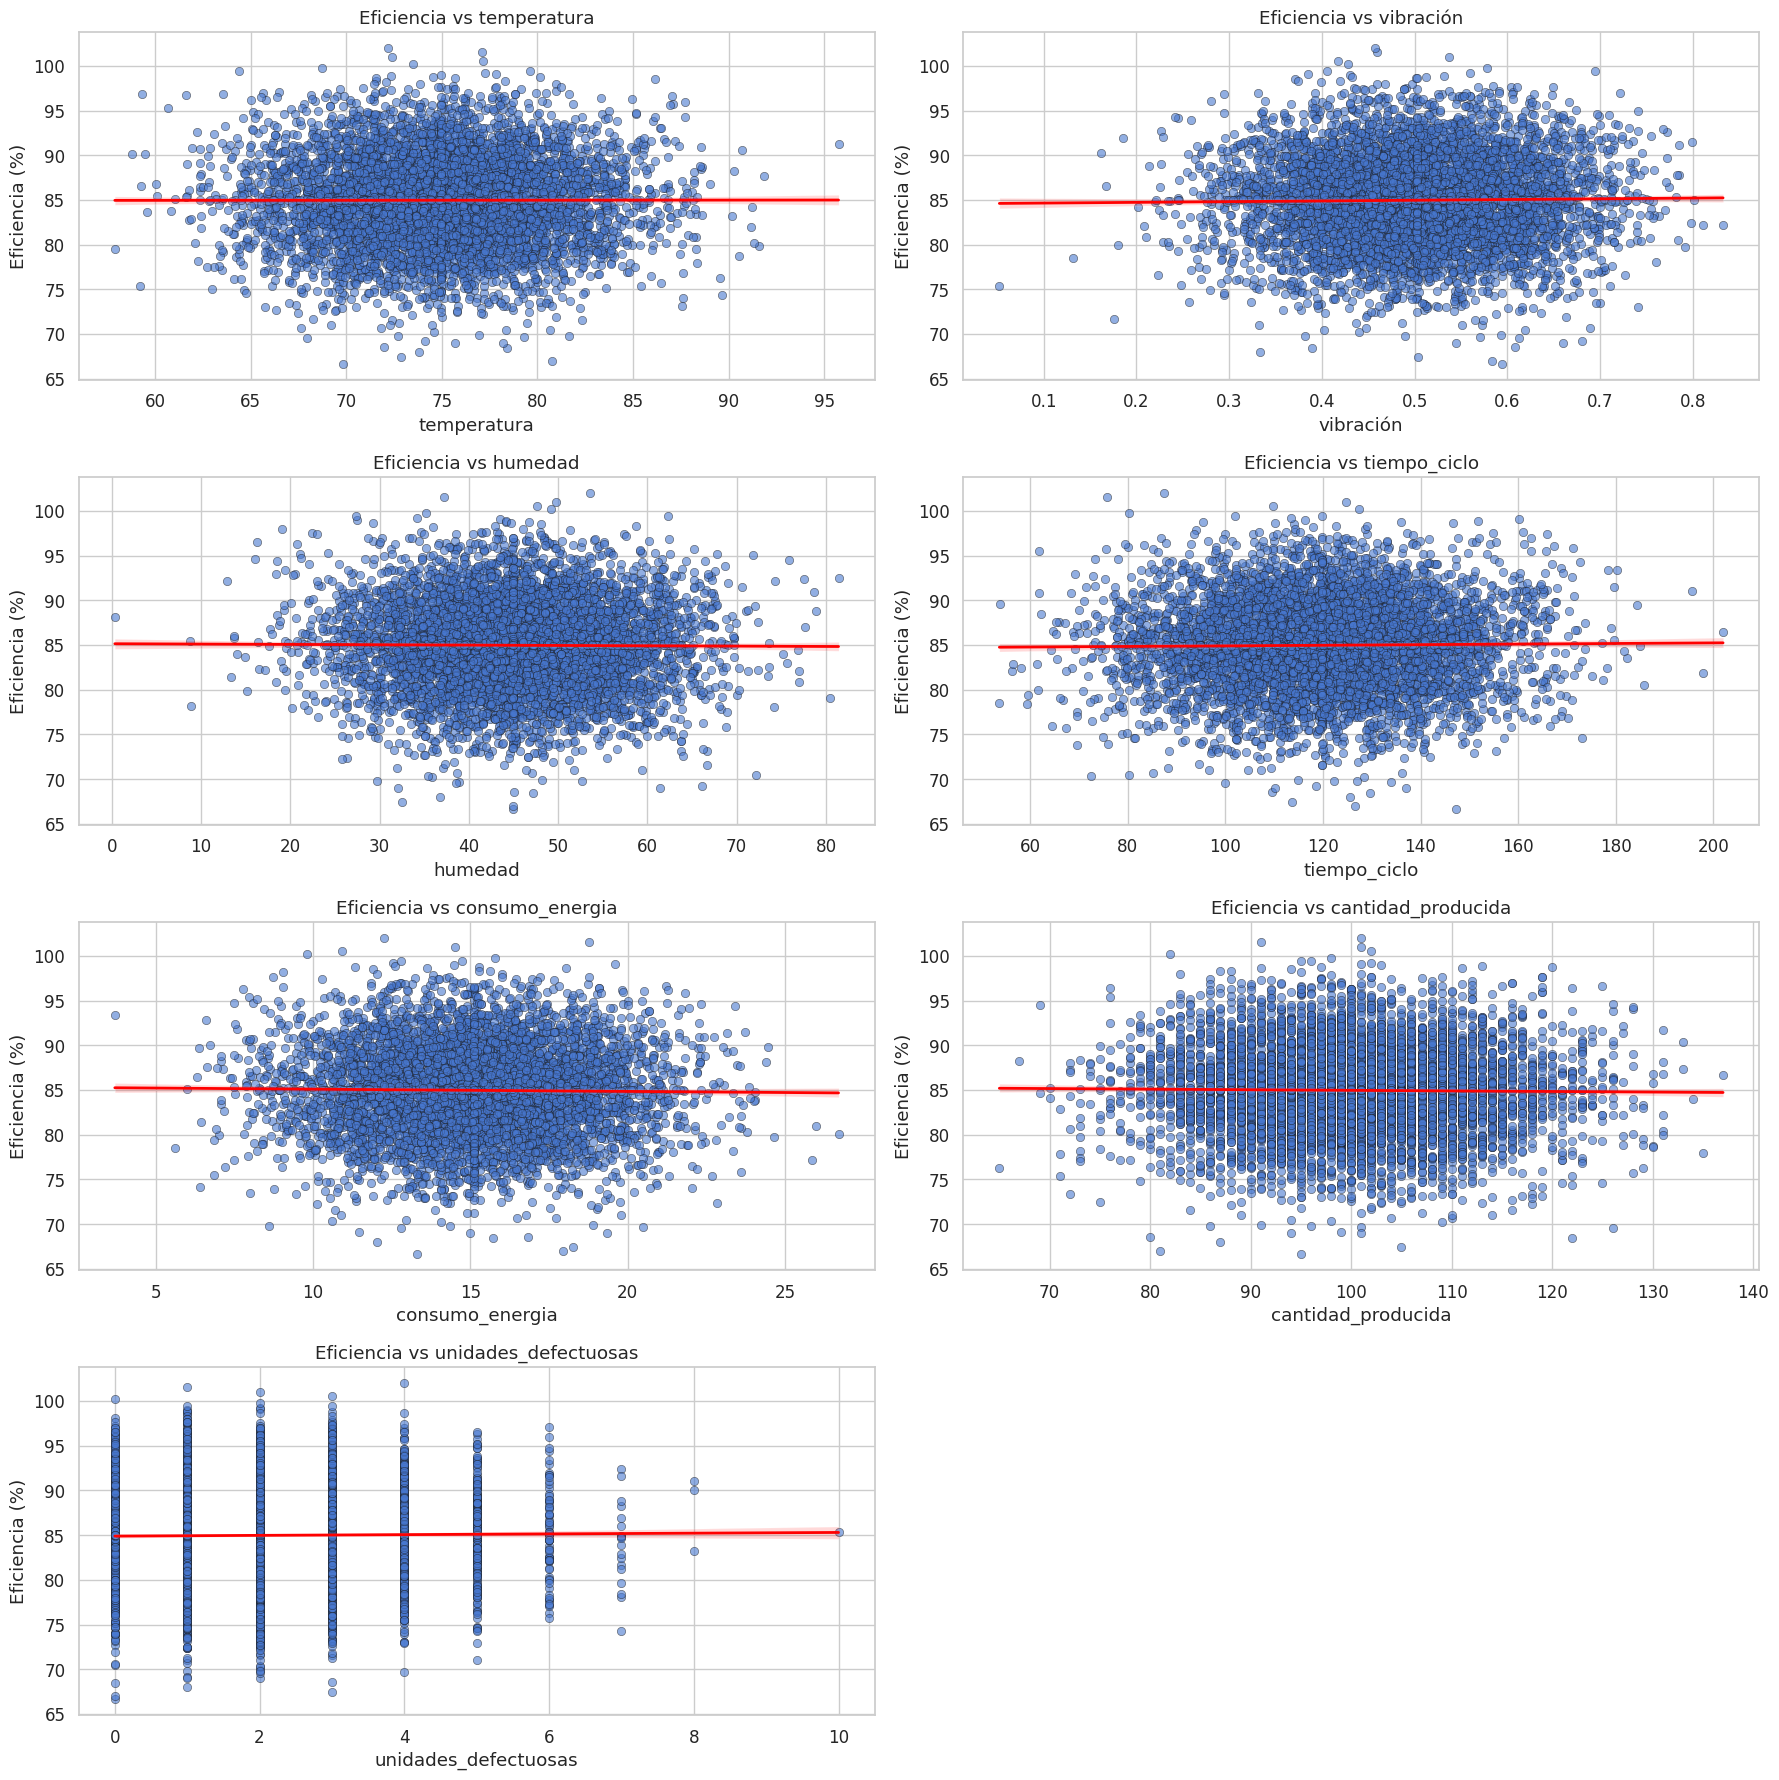

In [106]:
# Estilo general de los gráficos
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# Lista de variables numéricas para comparar con eficiencia
variables = [
    'temperatura', 'vibración', 'humedad', 'tiempo_ciclo',
    'consumo_energia', 'cantidad_producida', 'unidades_defectuosas'
]

# Tamaño de la figura general
plt.figure(figsize=(18, 18))

# Iterar para crear un subplot por cada variable
for i, variable in enumerate(variables, 1):
    plt.subplot(4, 2, i)
    sns.scatterplot(data=df, x=variable, y='eficiencia_porcentual', alpha=0.6, edgecolor='k')
    sns.regplot(data=df, x=variable, y='eficiencia_porcentual', scatter=False, color='red', line_kws={'lw': 2})
    plt.title(f'Eficiencia vs {variable}')
    plt.xlabel(variable)
    plt.ylabel('Eficiencia (%)')

# Ajuste final del diseño
plt.tight_layout()
plt.show()


# Modelo descriptivo para la base a predecir las variables más significativas

Este código implementa un modelo de **regresión con Random Forest** para predecir la eficiencia porcentual de producción en función de variables como temperatura, vibración, humedad y tiempo de ciclo. Se divide el conjunto de datos en entrenamiento y prueba, se entrena el modelo, se evalúa con MAE y R², y finalmente se grafica la importancia de cada variable predictora en la estimación del modelo. Esto permite identificar cuáles factores influyen más en la eficiencia del proceso.


MAE (Error absoluto medio): 4.08
R² (Coeficiente de determinación): -0.08


/tmp/ipython-input-107-3776979114.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




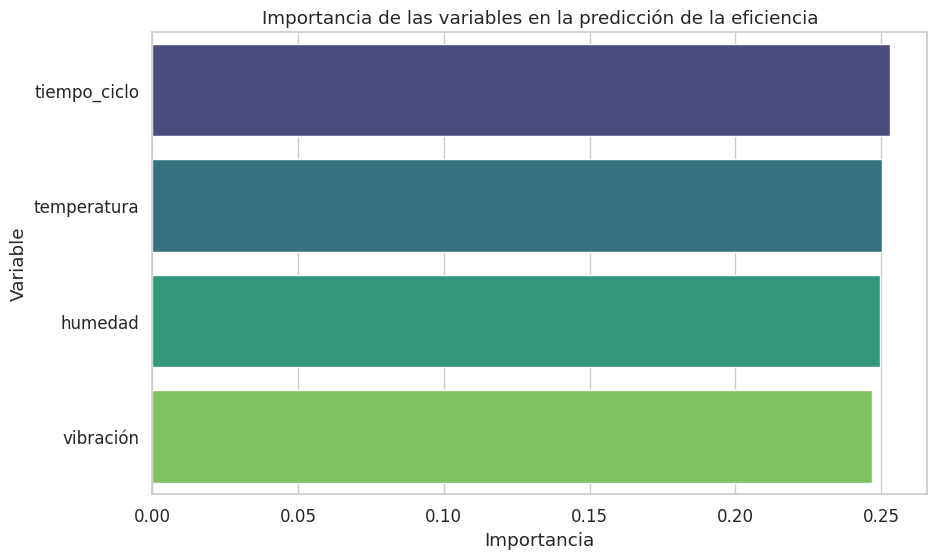

In [107]:
# Crear índice de defectos por si es útil para análisis
df['indice_defectos'] = (df['unidades_defectuosas'] / df['cantidad_producida']) * 100

# Variables predictoras (usando los nombres correctos)
features = ['temperatura','vibración','humedad','tiempo_ciclo']

X = pd.get_dummies(df[features], drop_first=True)
y = df['eficiencia_porcentual']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
modelo = RandomForestRegressor(n_estimators=300, random_state=42)
modelo.fit(X_train, y_train)

# Predicciones
y_pred = modelo.predict(X_test)

# Evaluación
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE (Error absoluto medio): {mae:.2f}")
print(f"R² (Coeficiente de determinación): {r2:.2f}")

# Importancia de variables
importancia = pd.Series(modelo.feature_importances_, index=X.columns).sort_values(ascending=False)

# Gráfico de importancia
plt.figure(figsize=(10,6))
sns.barplot(x=importancia.values[:15], y=importancia.index[:15], palette="viridis")
plt.title('Importancia de las variables en la predicción de la eficiencia')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

# Análisis de Rangos Óptimos de Operación para Maximizar la Eficiencia

Se implementó un análisis de sensibilidad para determinar los rangos óptimos de operación de variables clave del proceso, como temperatura, vibración, humedad, tiempo de ciclo y consumo de energía. Utilizando un modelo de Random Forest previamente entrenado, se simularon predicciones de eficiencia al variar individualmente cada variable, manteniendo las demás constantes. Se identificaron los intervalos en los que la eficiencia predicha se ubicó dentro del 10% superior, lo que permite definir condiciones ideales de operación que favorecen un mejor rendimiento productivo.

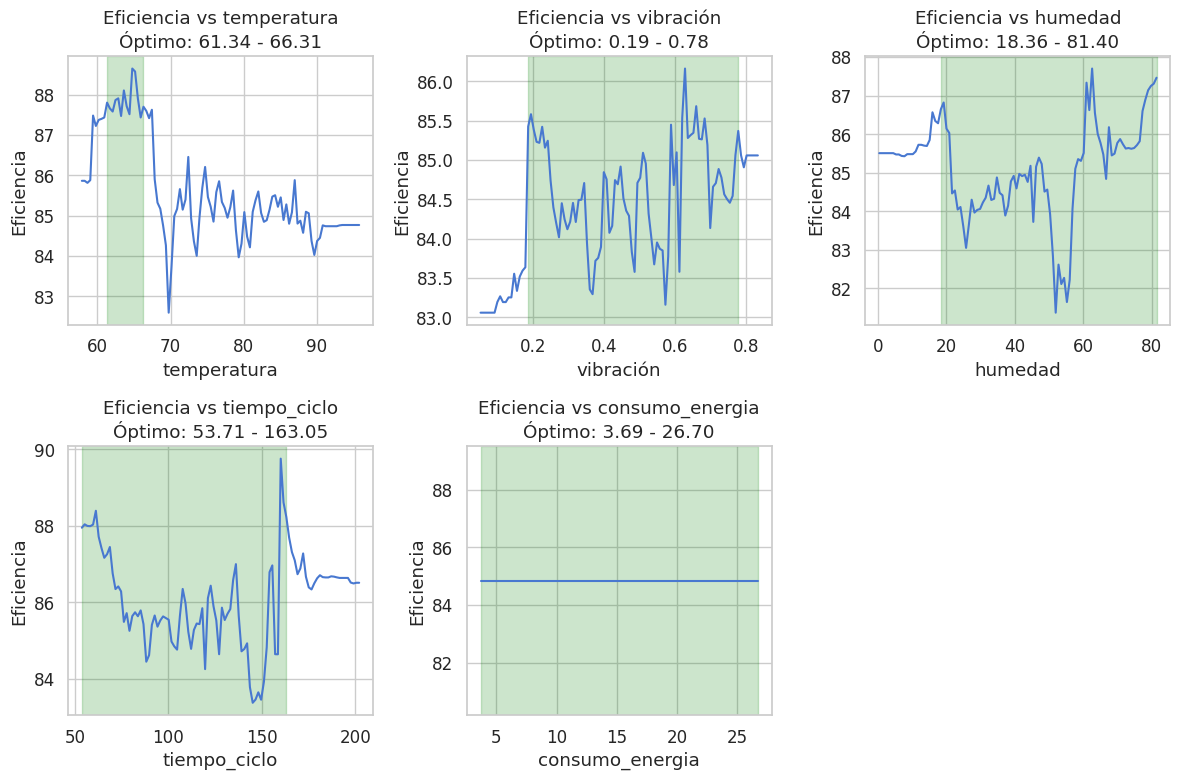

Rangos óptimos de operación (10% superior de eficiencia):
temperatura: 61.34 - 66.31
vibración: 0.19 - 0.78
humedad: 18.36 - 81.40
tiempo_ciclo: 53.71 - 163.05
consumo_energia: 3.69 - 26.70


In [108]:
def rango_optimo(var, modelo, X_base, steps=100, top_pct=0.1):
    X_temp = X_base.copy()
    valores = np.linspace(df[var].min(), df[var].max(), steps)
    eficiencias = []
    for v in valores:
        X_temp[var] = v
        X_dummies = pd.get_dummies(X_temp, drop_first=True).reindex(columns=X.columns, fill_value=0)
        pred = modelo.predict(X_dummies)[0]
        eficiencias.append(pred)
    eficiencias = np.array(eficiencias)
    # Umbral del top X% de eficiencia
    umbral = np.percentile(eficiencias, 100 - top_pct*100)
    valores_optimos = valores[eficiencias >= umbral]
    return (valores_optimos.min(), valores_optimos.max()), valores, eficiencias

# Fila base promedio
X_base = df[features].mean(numeric_only=True).to_frame().T
for col in ['maquina_id','turno','operador_id']:
    X_base[col] = df[col].mode()[0]

# Variables clave
vars_clave = ['temperatura','vibración','humedad','tiempo_ciclo','consumo_energia']
rangos_optimos = {}

plt.figure(figsize=(12,8))
for i, var in enumerate(vars_clave):
    rango, valores, eficiencias = rango_optimo(var, modelo, X_base)
    rangos_optimos[var] = rango
    plt.subplot(2,3,i+1)
    plt.plot(valores, eficiencias)
    plt.axvspan(rango[0], rango[1], color='green', alpha=0.2)
    plt.title(f'Eficiencia vs {var}\nÓptimo: {rango[0]:.2f} - {rango[1]:.2f}')
    plt.xlabel(var)
    plt.ylabel('Eficiencia')
plt.tight_layout()
plt.show()

# Imprimir rangos óptimos
print("Rangos óptimos de operación (10% superior de eficiencia):")
for var, r in rangos_optimos.items():
    print(f"{var}: {r[0]:.2f} - {r[1]:.2f}")


# Agrupar por operador y sumar las unidades defectuosas

In [109]:
df_defectos = df.groupby('operador_id')['unidades_defectuosas'].sum().reset_index()
df_defectos = df_defectos.sort_values(by='unidades_defectuosas', ascending=False)

# Encontrar operador con más y menos unidades defectuosas

In [110]:
# Seleccionar el operador con más unidades defectuosas (primera fila del DataFrame ya ordenado)
operador_max = df_defectos.iloc[0]

# Seleccionar el operador con menos unidades defectuosas (última fila del DataFrame ya ordenado)
operador_min = df_defectos.iloc[-1]

# Calcular la diferencia entre el máximo y el mínimo de unidades defectuosas
diferencia = operador_max['unidades_defectuosas'] - operador_min['unidades_defectuosas']

# Imprimir resultados con formato descriptivo
print(f" Operador con MÁS unidades defectuosas: {operador_max['operador_id']} -> {operador_max['unidades_defectuosas']}")
print(f" Operador con MENOS unidades defectuosas: {operador_min['operador_id']} -> {operador_min['unidades_defectuosas']}")
print(f"Diferencia de unidades defectuosas: {diferencia}")


 Operador con MÁS unidades defectuosas: OP_7 -> 667
 Operador con MENOS unidades defectuosas: OP_14 -> 520
Diferencia de unidades defectuosas: 147


# Gráfica con Seaborn (Top 10 operadores)

/tmp/ipython-input-111-1753040597.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




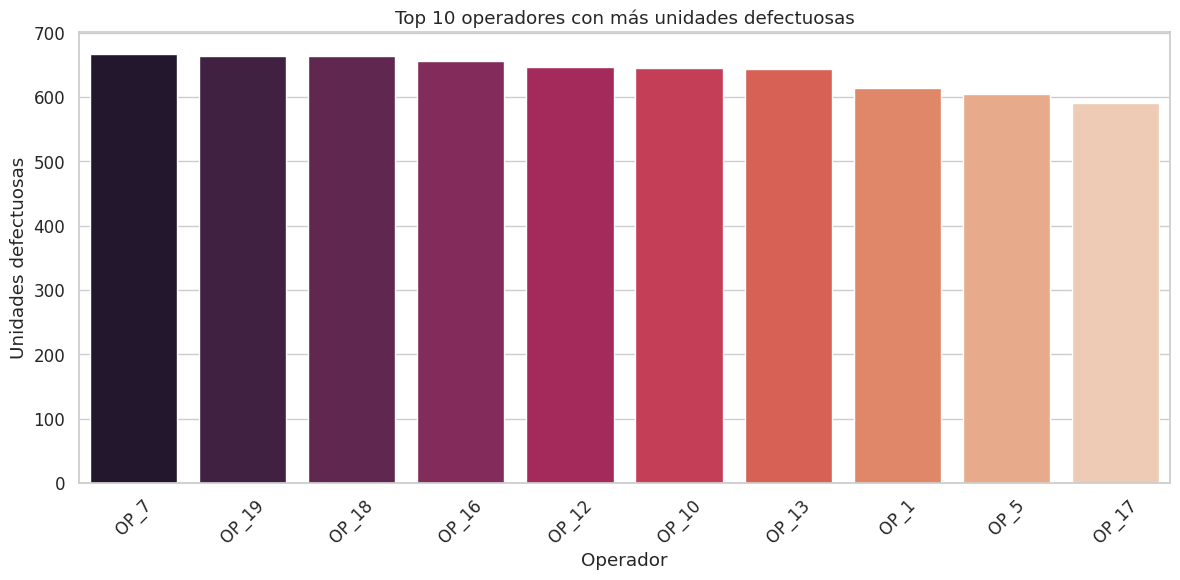

In [111]:
# Seleccionar las primeras 10 filas del DataFrame de defectos (asumido que ya están ordenadas por unidades defectuosas)
top_10 = df_defectos.head(10)

# Crear una figura de tamaño personalizado
plt.figure(figsize=(12,6))

# Crear gráfico de barras con seaborn para visualizar los operadores con más defectos
sns.barplot(data=top_10, x='operador_id', y='unidades_defectuosas', palette='rocket')

# Título y etiquetas del gráfico
plt.title('Top 10 operadores con más unidades defectuosas')
plt.xlabel('Operador')
plt.ylabel('Unidades defectuosas')

# Rotar etiquetas del eje X para mejor lectura
plt.xticks(rotation=45)

# Ajustar el diseño para evitar superposición
plt.tight_layout()

# Mostrar el gráfico
plt.show()


# Gráfica interactiva con Plotly, unidaddes defectuosas por trabajador

In [112]:

# Crear gráfico de barras con Plotly Express para visualizar defectos por operador
fig = px.bar(df_defectos,
             x='operador_id',  # Eje X: identificador del operador
             y='unidades_defectuosas',  # Eje Y: número de unidades defectuosas
             title='Unidades defectuosas por operador',  # Título del gráfico
             labels={'unidades_defectuosas': 'Unidades Defectuosas', 'operador_id': 'Operador'},  # Etiquetas personalizadas
             color='unidades_defectuosas',  # Colorear barras según cantidad de defectos
             color_continuous_scale='Reds')  # Escala de color en tonos rojos

# Ajustar la inclinación de las etiquetas del eje X para mejor visualización
fig.update_layout(xaxis_tickangle=-45)

# Mostrar el gráfico
fig.show()
